# Unsupervised machine leanring project
### Description:

This is the Week 5 Final project for the course unsupervised Machine Learning
Dataset used in this project is : <a https://archive.ics.uci.edu/dataset/179/secom>

Citation: McCann,Michael and Johnston,Adrian. (2008). SECOM. UCI Machine Learning Repository. https://doi.org/10.24432/C54305.


#### About the data:
This dataset was generated in a complex modern semi-conductor manufacturing process which was under consistent surveillance via the monitoring of signals collected from sensors and or process measurement points.It contains a large number of entries with different signals as features collected from sensors. There are 1567 examples with 590 features. Among these samples, the labels represent a simple pass/fail yield for in house line testing and associated data time stamp.there are 104 fails indicated by -1, and the rest are for the pass which represented by 1.

#### Problem:
There are too many features, and not all features are usefull and relevant. It is often the case that useful information is buried in the noise and useless information. This sensor data was generated under consistent suiveillance via the monitoring of signals/variables collefcted form sensors and or process measurement points, not all of these signals are euqally valuable. A proper way to reduce the number of features and or extract most variance from the data is essential for the final model.
#### ML approach:
A combination of feature selection methods to reduce the dimension of the sensor data.
Build two unsupervised clustering models and two supervised classifiers, using grideserach to tune hyperparameters of the models and compare between the models.

## Github link:

### EDA

In [822]:
# import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import seed

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Lasso

from imblearn.over_sampling import SMOTE
from collections import Counter 

from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [823]:
# seed
seed(401)

In [824]:
# load the variable sensors' data  
path="secom.data"
sensors=pd.read_csv(path,header=None,sep=' ')
sensors.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [825]:
# take a look at the data
sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, 0 to 589
dtypes: float64(590)
memory usage: 7.1 MB


 - sensors data has 1567 rows and 590 columns
 - sensors data only contains float data type

In [826]:
# rename columns
sensors.columns=['Sensor '+str(name) for name in sensors.columns]

In [827]:
# load the target senesor's data
path='secom_labels.data'
labels=pd.read_csv(path,header=None,sep=' ',names=['Label','Time'])
labels.head()

,Label,Time
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [828]:
# take a look at the data
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   1567 non-null   int64 
 1   Time    1567 non-null   object
dtypes: int64(1), object(1)
memory usage: 24.6+ KB


 - the labels data has 1567 rows and 2 columns
 - the lables data contains the information of the class(label) and datetime

In [829]:
# chenck the class(Label) information
labels.Label.value_counts()

-1    1463
 1     104
Name: Label, dtype: int64

 - class is imbalanced 

In [830]:
# Drop Time column from labels datetime
labels.drop(labels='Time',axis=1,inplace=True)

In [831]:
# merge data
data_original=pd.concat([sensors,labels],axis=1)
data_original.head()

,Sensor 0,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,...,Sensor 581,Sensor 582,Sensor 583,Sensor 584,Sensor 585,Sensor 586,Sensor 587,Sensor 588,Sensor 589,Label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [832]:
# encode classes (defalut product:1,good product:0)
data_original.replace(to_replace=1,value=0,inplace=True)
data_original.replace(to_replace=-1,value=1,inplace=True)
data_original.head()

,Sensor 0,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,...,Sensor 581,Sensor 582,Sensor 583,Sensor 584,Sensor 585,Sensor 586,Sensor 587,Sensor 588,Sensor 589,Label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1


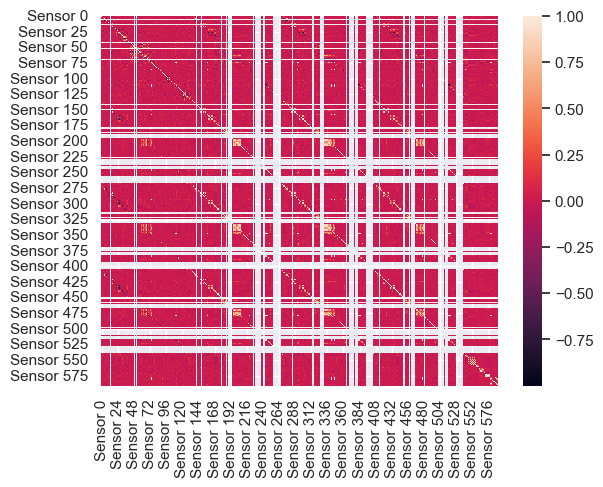

In [833]:
# plot correlation heatmap
sns.heatmap(data_original.corr());

There are too many features in the dataset but we can get a general idea from the heatmap that the columns of this dataset are highly correlated and there are mulitcolinality. 

In [834]:
# checking missing values
vars_with_na=[var for var in data_original.columns if data_original[var].isnull().sum()>0]
len(vars_with_na)

538

 -there are 538 columns contain missing values

In [835]:
# find out the percentage of observations missing per variable
data_na=data_original[vars_with_na].isnull().mean()
data_na=pd.DataFrame(data_na.reset_index())

# add column names to the result dataframe
data_na.columns=['variable','NA_%']
data_na.sort_values(by='NA_%',ascending=False,inplace=True)
data_na.head(10)

,variable,NA_%
269,Sensor 292,0.911934
270,Sensor 293,0.911934
145,Sensor 157,0.911934
146,Sensor 158,0.911934
335,Sensor 358,0.855775
84,Sensor 85,0.855775
458,Sensor 492,0.855775
208,Sensor 220,0.855775
481,Sensor 518,0.649649
231,Sensor 246,0.649649


In [836]:
data_na.tail(10)

,variable,NA_%
301,Sensor 324,0.000638
302,Sensor 325,0.000638
419,Sensor 453,0.000638
420,Sensor 454,0.000638
421,Sensor 455,0.000638
422,Sensor 456,0.000638
206,Sensor 218,0.000638
333,Sensor 356,0.000638
423,Sensor 457,0.000638
537,Sensor 589,0.000638


 - there are some columns contain high percentage of missing values.
 - we need to discard those columns as they are meaningless.
 - Only keep the columns that have missing values smaller than 5%

In [837]:
# capture variables with no or less than 5% NA

vars_ = [var for var in data_original.columns 
         if data_original[var].isnull().mean() < 0.05]
len(vars_)


539

In [838]:
# update the data
data=data_original[vars_].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 539 entries, Sensor 0 to Label
dtypes: float64(538), int64(1)
memory usage: 6.4 MB


- because there are some missing data need to be filled might be based on the statistics of the data, need to split the data into trainging and testing dataset. 

In [839]:
# split the data
X_train,X_test,y_train,y_test=train_test_split(data.iloc[:,:-1],data.Label,
                                               test_size=0.2,random_state=420)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1253, 538), (314, 538), (1253,), (314,))

- impute missing values by random sampling from training data

In [840]:
# numbers of NA in training and testing data set before NA imputation
# X_train.isnull().sum().sum(),X_test.isnull().sum().sum()
print(f'There are {X_train.isnull().sum().sum()} missing data in training dataset')
print(f'There are {X_test.isnull().sum().sum()} missing data in testing dataset')

There are 2896 missing data in training dataset
There are 623 missing data in testing dataset


In [841]:
def fill_na(df_train,df_test,var):
    # fucntion to fill NA in both training and testing set by random sampling
    # from training data
    
    # extract the number of missing values(sample numbers)
    n=df_train[var].isnull().sum()
    m=df_test[var].isnull().sum()
    
    # random sampling from training set
    
    random_state1=n # set the random_state unique to each sample
    random_sample_train=df_train[var].dropna().sample(n,random_state=n)
    
    random_state2=m
    random_sample_test=df_train[var].dropna().sample(m,random_state=m)
    
    # set the same index in order to merge datasets
    random_sample_train.index = df_train[df_train[var].isnull()].index
    random_sample_test.index = df_test[df_test[var].isnull()].index
    
    # replace NA
    df_train.loc[df_train[var].isnull(),var]=random_sample_train
    df_test.loc[df_test[var].isnull(),var]=random_sample_test
    
#     return df_train[var],df_test[var]

In [842]:
# fill NA in each column that contains missing values 
for i in list(vars_[:-1]):
    fill_na(X_train,X_test,i)
# number of missing data after NA imputation
# X_train.isnull().sum().sum(),X_test.isnull().sum().sum()
print(f'There are {X_train.isnull().sum().sum()} missing data in training dataset')
print(f'There are {X_test.isnull().sum().sum()} missing data in testing dataset')

There are 0 missing data in training dataset
There are 0 missing data in testing dataset


### feature selecting 

In [843]:
# remove constant features as they provide 
# no information to discriminate the target
constant_features=[feat for feat in X_train.columns if X_train[feat].std()==0]
X_train.drop(labels=constant_features,axis=1,inplace=True)
X_test.drop(labels=constant_features,axis=1,inplace=True)

X_train.shape,X_test.shape

((1253, 416), (314, 416))

In [844]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)

duplicated_feat=set(duplicated_feat)            
len(duplicated_feat)

0

In [845]:
# save a copy for later analysis
X_train_before=X_train
X_test_before=X_test
y_train_before=y_train
y_test_before=y_test

In [846]:
X_train_before.shape,X_test_before.shape,y_train_before.shape,y_test_before.shape

((1253, 416), (314, 416), (1253,), (314,))

 - there are no duplicated features

In [847]:
# remove features that contains most of the same values
low_var=[]
for var in X_train.columns:
    # get the features that more than 98% of values are the same
    if max(X_train[var].value_counts()/len(X_train))>0.98:
        low_var.append(var)
print(len(low_var))

4


In [848]:
# remove features
X_train.drop(labels=low_var,axis=1,inplace=True)
X_test.drop(labels=low_var,axis=1,inplace=True)

X_train.shape,X_test.shape

((1253, 412), (314, 412))

In [849]:
#  fucntion to remove correlated features
def correlation(dataset, threshold):
    # function to remove correlated features
    # remove features that have absolute correlation value that above threshold
    
    col_corr = set()  # Set of correlated features
    
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    return col_corr


In [850]:
# numbers of correlated features
corr_features = correlation(X_train, 0.8)
print(f'correlated features: {len(set(corr_features))} ')

correlated features: 201 


In [851]:
# remove correlated features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((1253, 211), (314, 211))

In [852]:

# scaler
scaler=StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [853]:
# make a copy of the data before using LASSO for later
X_train_blasso = X_train
X_test_blasso = X_test
y_train_blasso = y_train
y_test_blasso = y_test

In [854]:
X_train_blasso.shape,X_test_blasso.shape,y_train_blasso.shape,y_test_blasso.shape

((1253, 211), (314, 211), (1253,), (314,))

In [855]:
# LASSO
alpha=0.0225
clf=Lasso(alpha=alpha,random_state=420)
clf.fit(scaler.transform(X_train),y_train)
# print(clf.coef_)
_list=X_train.columns[clf.coef_!=0]
len(_list)

5

In [856]:
# columns that are selected
_list

Index(['Sensor 21', 'Sensor 59', 'Sensor 64', 'Sensor 103', 'Sensor 210'], dtype='object')

There are only 5 column left after LASSO 

In [857]:
# update the features of the train-test set
X_train=X_train[_list]
X_test=X_test[_list]
X_train.shape, X_test.shape

((1253, 5), (314, 5))

### further EDA and data cleaning

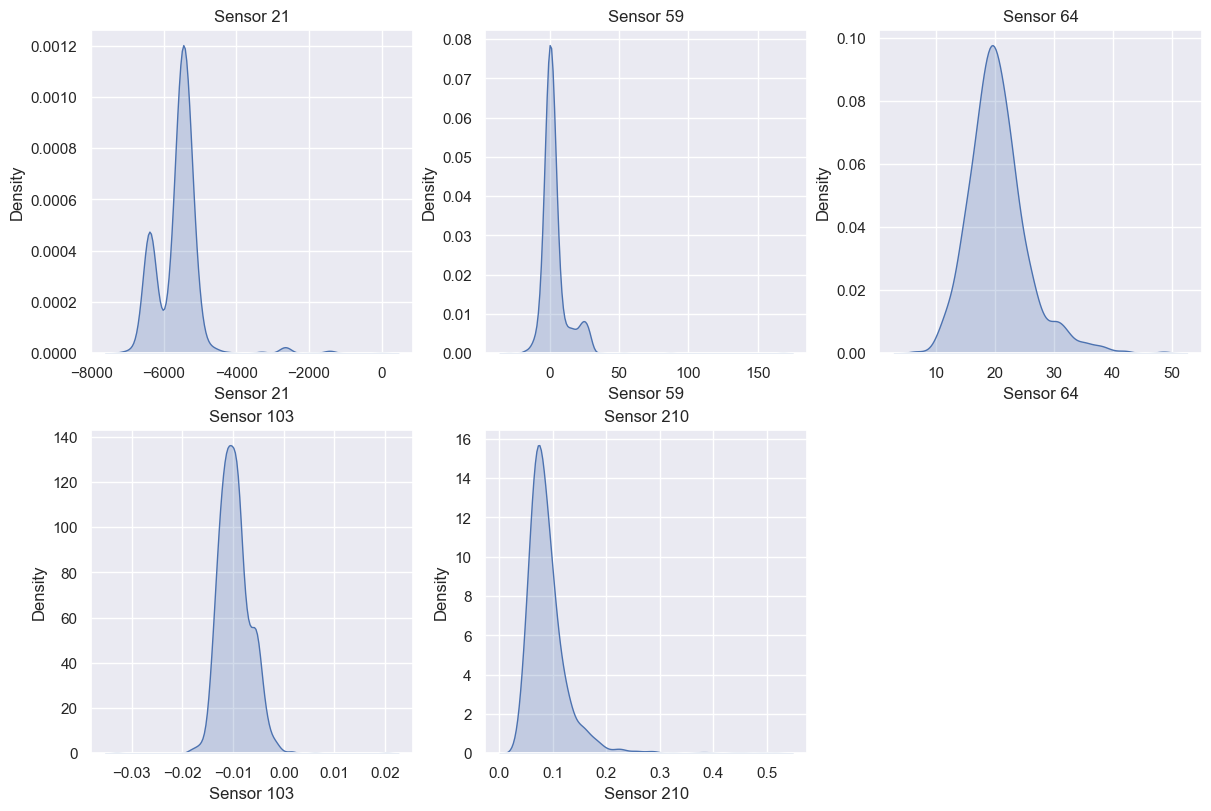

In [858]:
# visually explore the training dataset
def trim_axs(axs,N):
    # function to trim apare axs
    axs=axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

cases=X_train.columns
axs=plt.figure(figsize=(12,8),constrained_layout=True).subplots(2,3)
axs=trim_axs(axs,len(cases))
for ax,case in zip(axs,cases):
    ax.set_title(f'{case}',fontsize=12)
    sns.kdeplot(x=case,data=X_train,ax=ax,fill=True)

The distribution of sensor 21, sensor 59 has two peaks, and distribution of sensor 64,sensor 103 and sensor 210 are normal like shape with some variation on the right tail.

In [859]:
# function to create histogram, Q-Q plot and boxplot

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments
    
    # for Q-Q plots
    import scipy.stats as stats
    
    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.kdeplot(x=variable,data=df,fill=True)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [860]:
def find_skewed_boundaries(df, variable, distance):

    # fucntion to calculate the boundaries 
    # for skewed distributions

    # distance passed as an argument

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

plots of Sensor 21


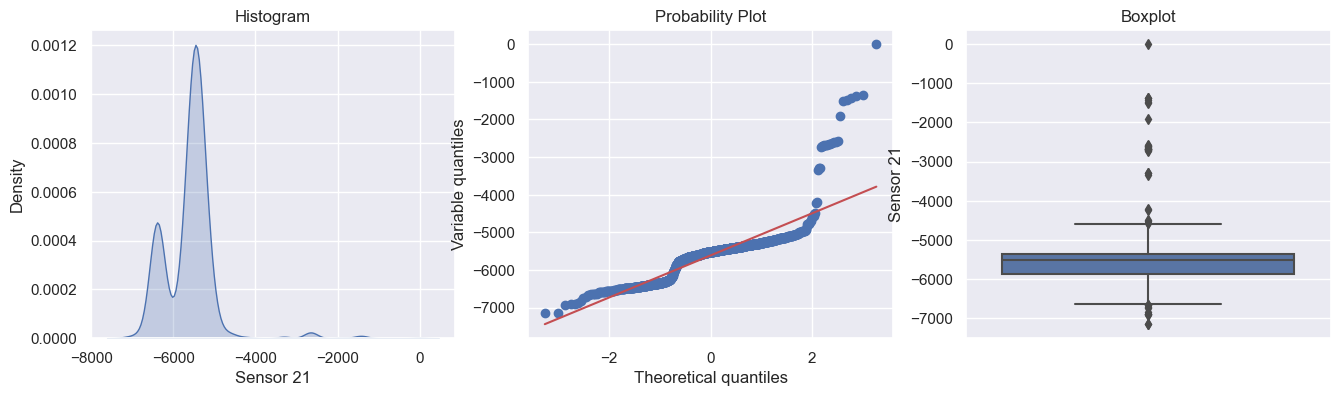

In [861]:
# find outliers in Sensor 21
print('plots of Sensor 21')
diagnostic_plots(X_train, 'Sensor 21')

- there are a lot of outliers in the right tail
- the distribution has two peaks
- the distribution is not normal based on the Q-Q plot

In [862]:
# find the maximum and minimum limit
upper,lower=find_skewed_boundaries(X_train, 'Sensor 21', 2)

# replace the outliers by the maximum and minimum limit
X_train_=pd.DataFrame()
X_train_.loc[:,'Sensor 21']= np.where(X_train.loc[:,'Sensor 21']>upper,upper,
                       np.where(X_train.loc[:,'Sensor 21']<lower,lower, X_train.loc[:,'Sensor 21']))

plots of Sensor 21 after removing outliers


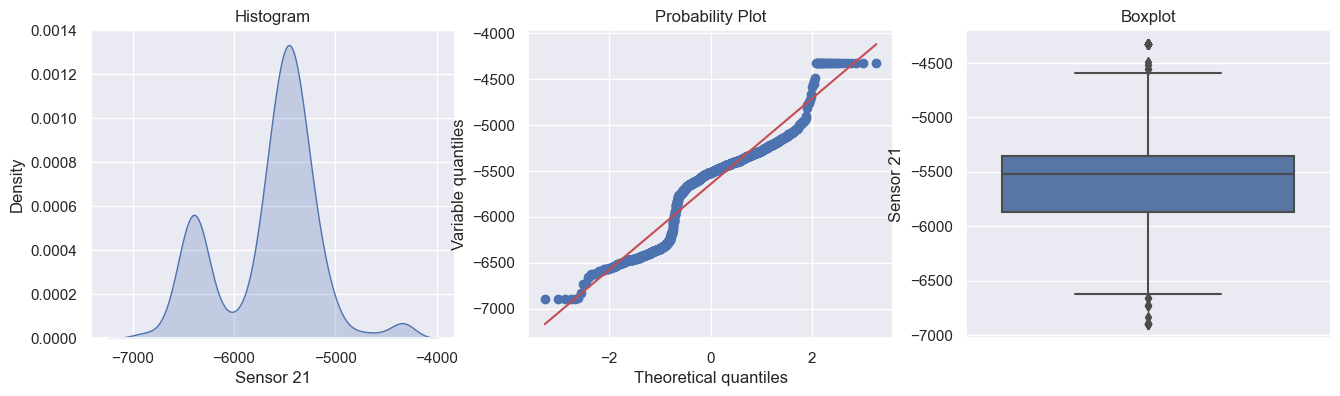

In [863]:
# plots after outlier removal
print('plots of Sensor 21 after removing outliers')
diagnostic_plots(X_train_, 'Sensor 21')

- there are two peaks in the distribution
- there are still outliers but not as significant as before

plots of Sensor 59


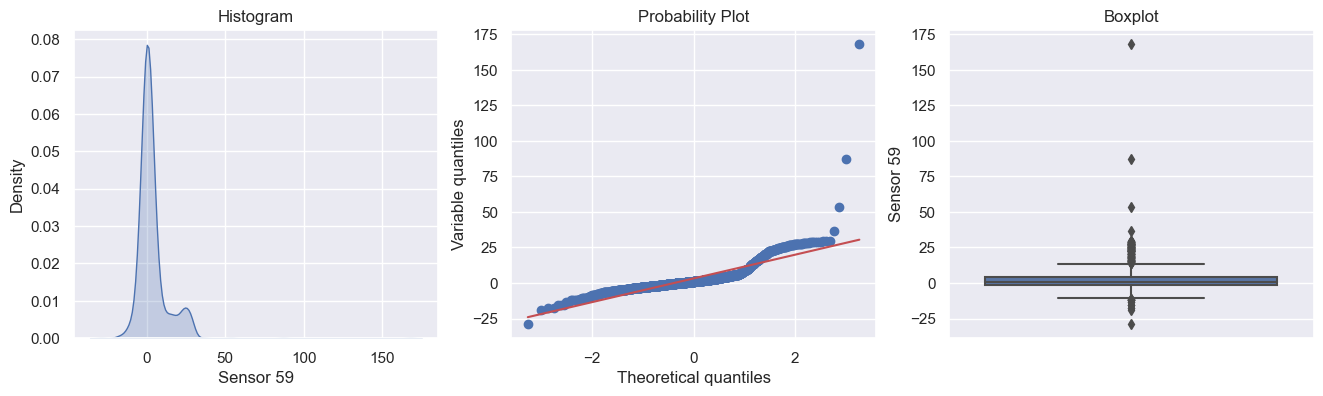

In [864]:
# find outliers in Sensor 59
print('plots of Sensor 59')
diagnostic_plots(X_train, 'Sensor 59')

- distribution plot and Q-Q plot show the dataset is normal-like shape with outliers most on the right tail.

In [865]:
# find the maximum and minimum limit
upper=np.quantile(X_train['Sensor 59'],0.97)
lower=np.quantile(X_train['Sensor 59'],0.01)

# replace the outliers by the maximum and minimum limit
X_train_.loc[:,'Sensor 59']= np.where(X_train.loc[:,'Sensor 59']>upper,upper,
                       np.where(X_train.loc[:,'Sensor 59']<lower,lower, X_train.loc[:,'Sensor 59']))

plots of Sensor 59 after removing outliers


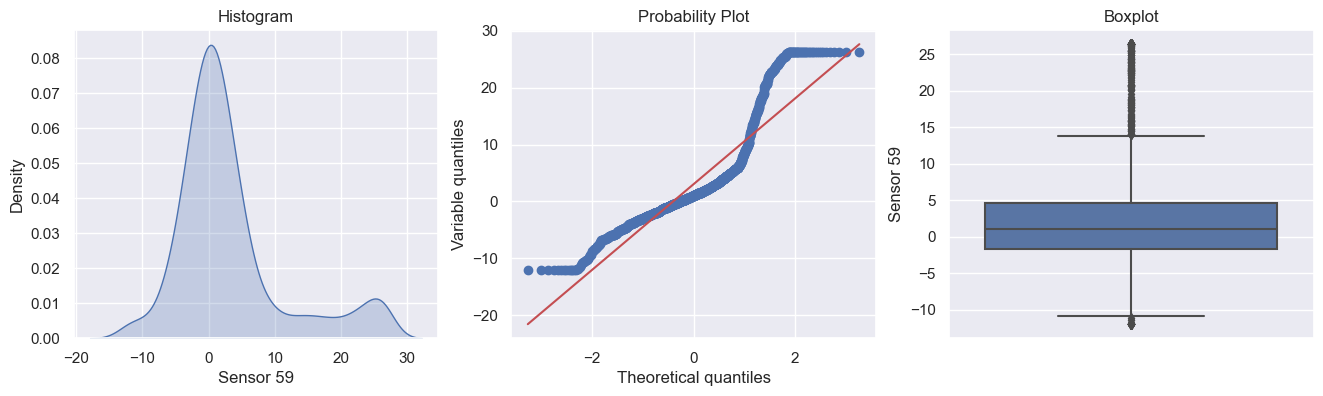

In [866]:
# plots after outlier removal 
print('plots of Sensor 59 after removing outliers')
diagnostic_plots(X_train_, 'Sensor 59')

- there are less outliers 

plots of Sensor 64


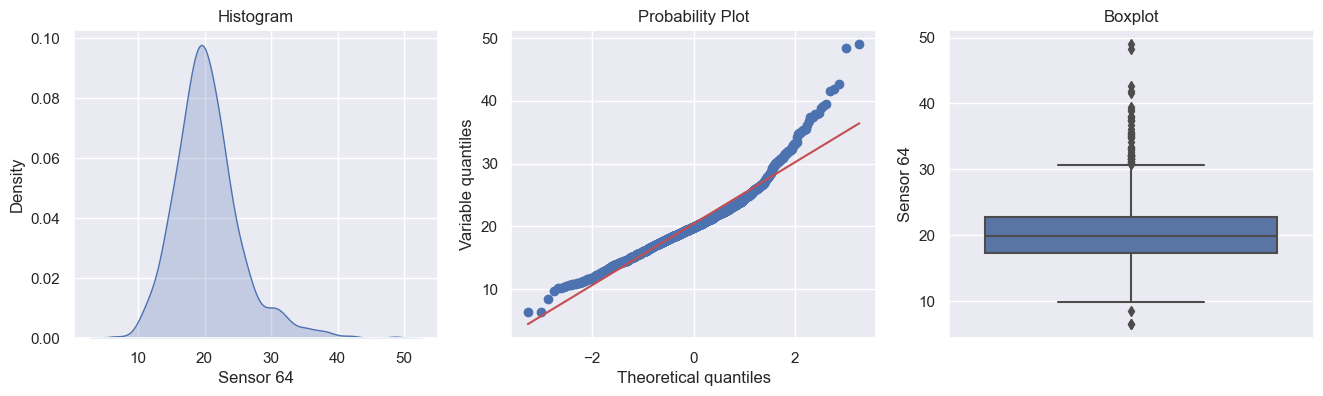

In [867]:
# find outliers in Sensor 64
print('plots of Sensor 64')
diagnostic_plots(X_train, 'Sensor 64')

- distribution is normal-like shape with outliers on both sides but mostly on the right tail.

In [868]:
# find the maximum and minimum limit
upper=np.quantile(X_train['Sensor 64'],0.98)
lower=np.quantile(X_train['Sensor 64'],0.01)
# replace the outliers by the maximum and minimum limit
X_train_.loc[:,'Sensor 64']= np.where(X_train.loc[:,'Sensor 64'] >upper,upper,
                       np.where(X_train.loc[:,'Sensor 64'] <lower,lower, X_train.loc[:,'Sensor 64']))

plots of Sensor 64 after removing outliers


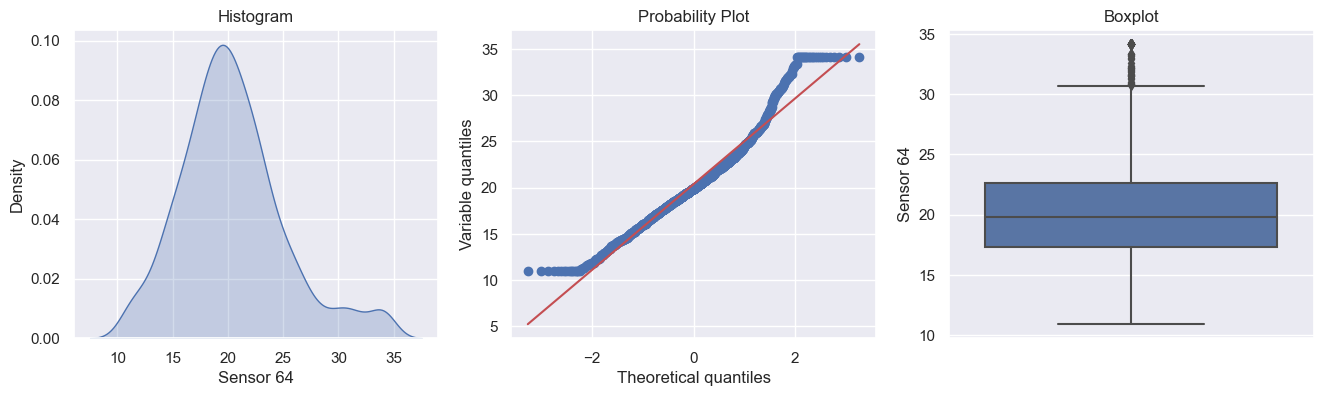

In [869]:
# plots after outlier removal
print('plots of Sensor 64 after removing outliers')
diagnostic_plots(X_train_, 'Sensor 64')

- distribution is closer to normal than before but still with variations on right tail
- outliers are mostly gone

plots of Sensor 103


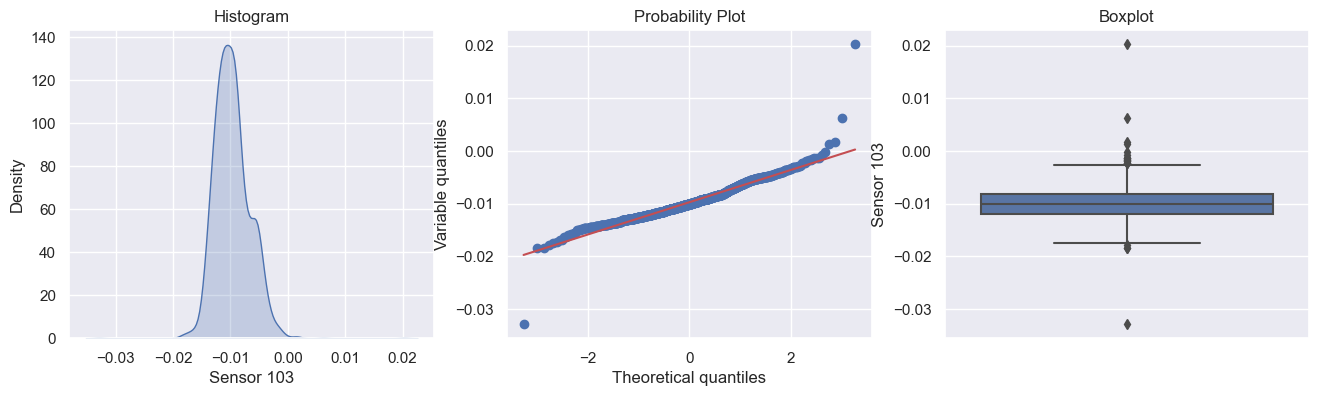

In [870]:
# find outliers in Sensor 103
print('plots of Sensor 103')
diagnostic_plots(X_train, 'Sensor 103')

- distribution is normal-like shape with outliers on both sides 

In [871]:
upper=np.quantile(X_train['Sensor 103'],0.99)
lower=np.quantile(X_train['Sensor 103'],0.01)
# replace the outliers by the maximum and minimum limit
X_train_.loc[:,'Sensor 103']= np.where(X_train.loc[:,'Sensor 103']>upper,upper,
                       np.where(X_train.loc[:,'Sensor 103'] <lower,lower, X_train.loc[:,'Sensor 103']))

plots of Sensor 103 after removing outliers


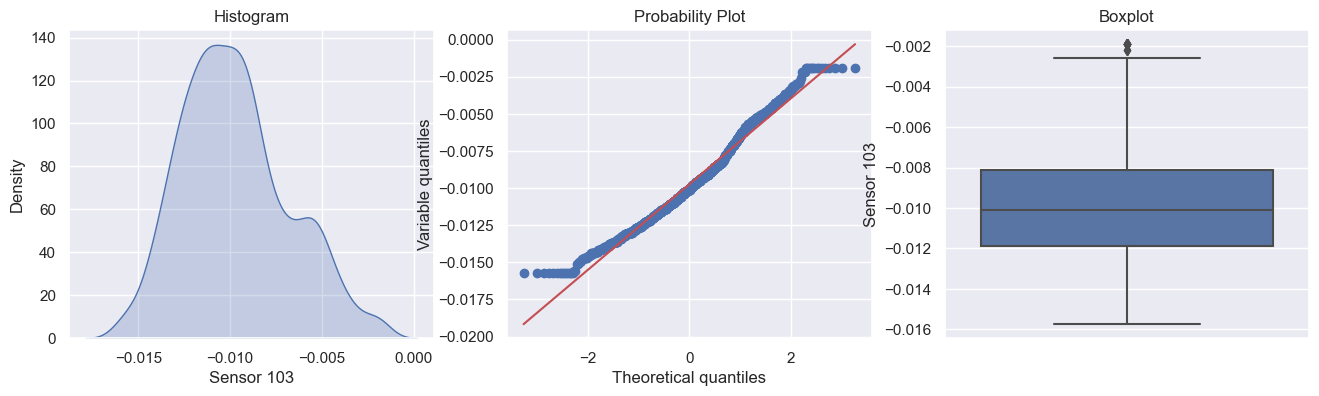

In [872]:
# plot after outlier removal 
print('plots of Sensor 103 after removing outliers')
diagnostic_plots(X_train_,'Sensor 103')

- distribution is closer to normal than before but still with variations on right tail
- outliers are most gone

plots of Sensor 210


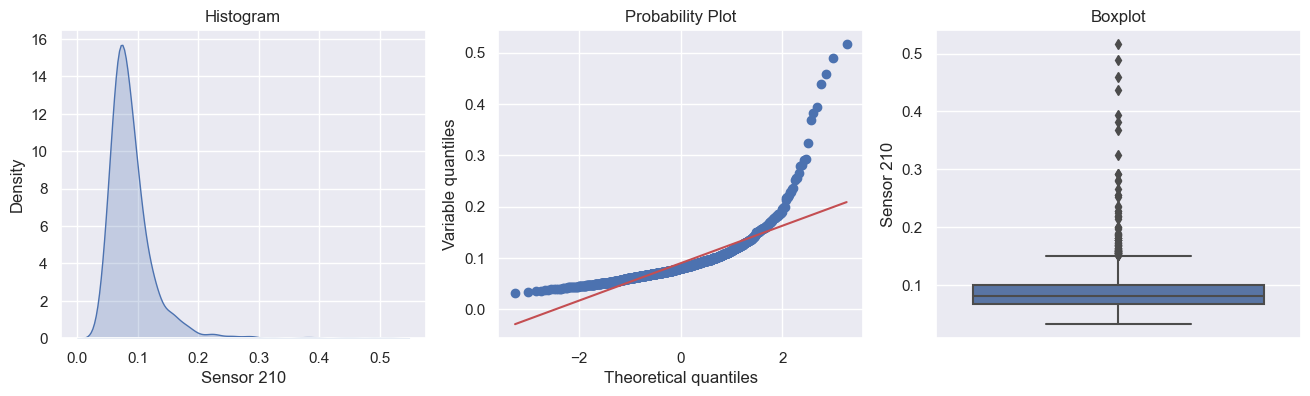

In [873]:
# find outliers in Sensor 210
print('plots of Sensor 210')
diagnostic_plots(X_train,'Sensor 210')

- distribution is normal-like shape with outliers on the right tail

In [874]:
upper=np.quantile(X_train['Sensor 210'],0.98)
lower=np.quantile(X_train['Sensor 210'],0.01)
# replace the outliers by the maximum and minimum limit
X_train_.loc[:,'Sensor 210']= np.where(X_train.loc[:,'Sensor 210']>upper,upper,
                       np.where(X_train.loc[:,'Sensor 210'] <lower,lower, X_train.loc[:,'Sensor 210']))

plots of Sensor 210 after removing outliers


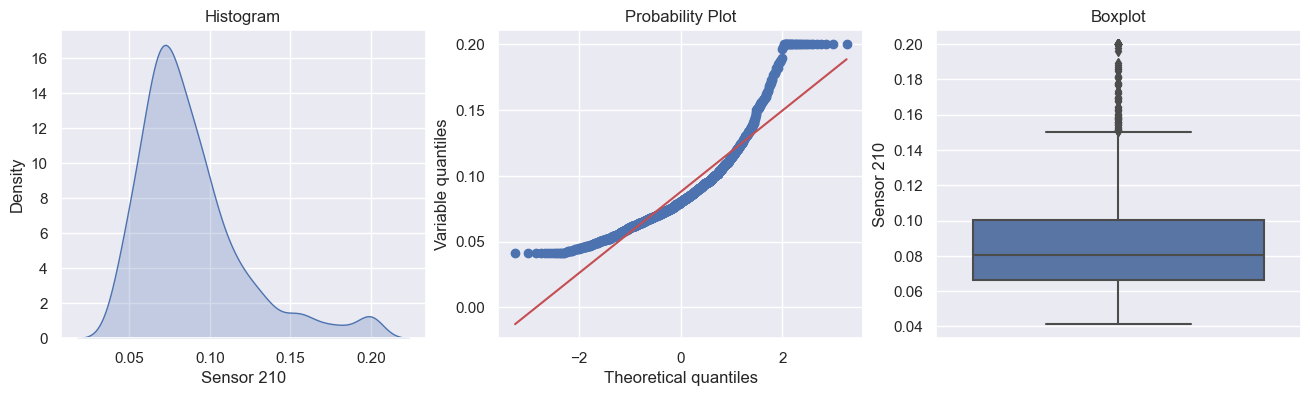

In [875]:
# plot after outlier removal 
print('plots of Sensor 210 after removing outliers')
diagnostic_plots(X_train_, 'Sensor 210')

- distribution is closer to normal than before but still with variations on the right tail
- there are less outliers

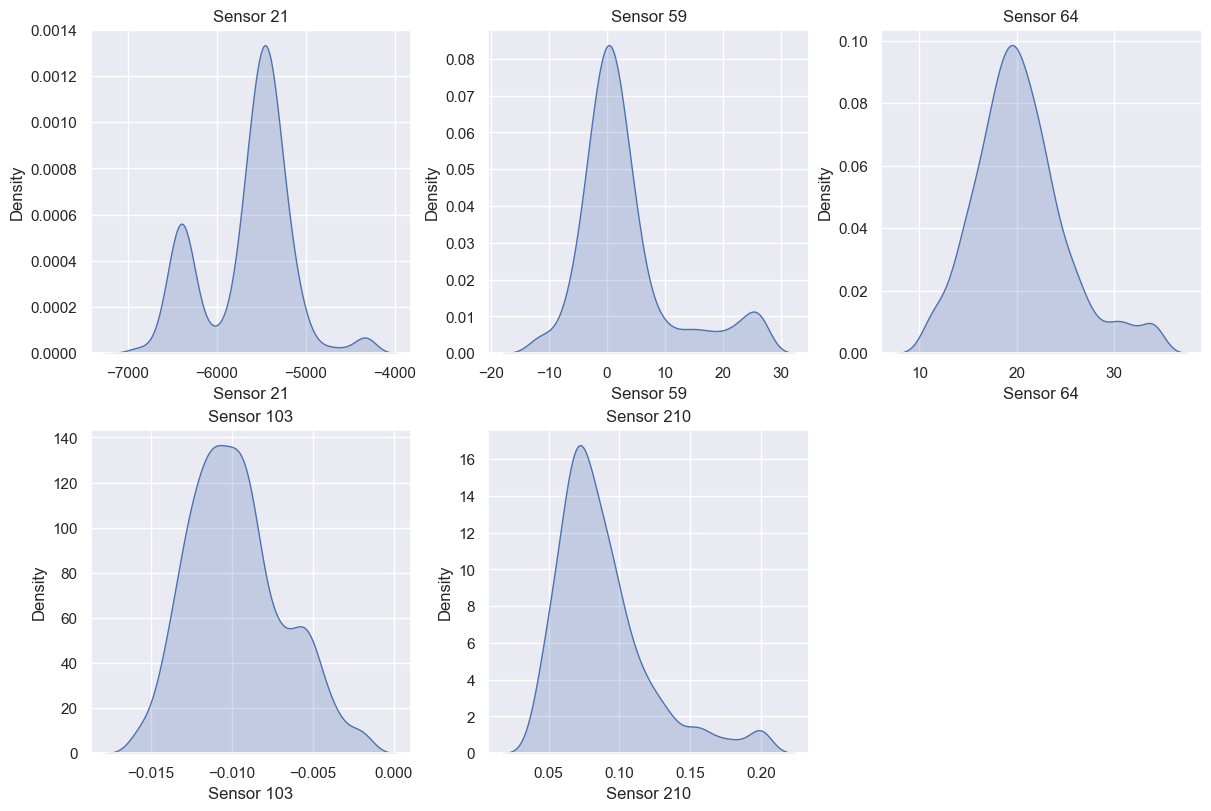

In [876]:
# visually explore the training dataset after cleaning the data
def trim_axs(axs,N):
    # function to trim apare axs
    axs=axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

cases=X_train_.columns
axs=plt.figure(figsize=(12,8),constrained_layout=True).subplots(2,3)
axs=trim_axs(axs,len(cases))
for ax,case in zip(axs,cases):
    ax.set_title(f'{case}',fontsize=12)
    sns.kdeplot(x=case,data=X_train_,ax=ax,fill=True)

- outliers are less significant 
- distribtuions were distorted a bit on the right tails mostly

### resample classes 

In [877]:
# check the numbers of each class
y_train.value_counts()

1    1171
0      82
Name: Label, dtype: int64

In [878]:
def smote_resample(x,y,random_state=420):
    # using SMOTE to balance the calsses
    sm=SMOTE(random_state=random_state)
    X_res,y_res=sm.fit_resample(x,y)
    # update dataset
    X_balanced=pd.DataFrame(X_res,columns=X_train_.columns)
    y_balanced=y_res
    return X_balanced,y_balanced

In [879]:
X_train_balanced,y_train_balanced=smote_resample(X_train_,y_train)

# using SMOTE to balance the calsses
sm=SMOTE(random_state=420)
X_res,y_res=sm.fit_resample(X_train_,y_train)

# update dataset
X_train_balanced=pd.DataFrame(X_res,columns=X_train_.columns)
y_train_balanced=y_res

In [880]:
# number of examples after applying the algorithm
print(f"Original dataset length is {len(X_train_)}")

#number of original dataset
print(f"Original dataset shape is:{sorted(Counter(y_train).items())}")

# number of examples after applying the algorithm
print(f"Resampled dataset length is {len(X_train_balanced)}")

# examples for each class
print(f"Resampled dataset shape is:{sorted(Counter(y_train_balanced).items())}")


Original dataset length is 1253
Original dataset shape is:[(0, 82), (1, 1171)]
Resampled dataset length is 2342
Resampled dataset shape is:[(0, 1171), (1, 1171)]


In [881]:
X_test.shape

(314, 5)

In [882]:
# get data ready for model
x_train=X_train_balanced.values
x_test=X_test.values

y_train=y_train_balanced.values
y_test=y_test


In [883]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2342, 5), (314, 5), (2342,), (314,))

In [884]:
# scale 
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)

In [885]:
x_test=scaler.transform(x_test)


### Model building and compareing

In [886]:
from sklearn.metrics import accuracy_score
compare = pd.DataFrame(index = ['BKM','SVC','RF','BKM_PCA','SVC_PCA','RF_PCA'],columns=['training_acc','testing_acc'])

#### Build a bisectingkmean model and find the best parameter for it

In [887]:
from sklearn.model_selection import GridSearchCV
parameters = {'init':('k-means++', 'random'), 'n_init':[1, 10],
             'max_iter':[200,300],'algorithm':['lloyd','elkan'],
             'bisecting_strategy':['biggest_inertia','largest_cluster']}
BKM = BisectingKMeans(n_clusters=2,random_state=401)
clf = GridSearchCV(BKM, parameters)
clf.fit(x_train,y_train)

print(clf.cv_results_.keys())
print(clf.best_params_)
print(clf.best_score_)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_algorithm', 'param_bisecting_strategy', 'param_init', 'param_max_iter', 'param_n_init', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'algorithm': 'lloyd', 'bisecting_strategy': 'biggest_inertia', 'init': 'random', 'max_iter': 200, 'n_init': 1}
-1804.319000946841


In [888]:
bisect_means = BisectingKMeans(n_clusters=2,random_state=401,init='random',
                               n_init=1,bisecting_strategy='biggest_inertia',
                              algorithm='lloyd',max_iter=200).fit(x_train)
y_hat=bisect_means.predict(x_test)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.05      0.59      0.09        22
           1       0.83      0.15      0.26       292

    accuracy                           0.18       314
   macro avg       0.44      0.37      0.17       314
weighted avg       0.78      0.18      0.24       314



In [889]:
# becaUse the class label was randomly assigned to the cluster, we can reassign the class lable
# fix the predicted class lable
y_hat = [1 if x==0 else 0 for x in y_hat]
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.17      0.41      0.24        22
           1       0.95      0.85      0.90       292

    accuracy                           0.82       314
   macro avg       0.56      0.63      0.57       314
weighted avg       0.90      0.82      0.85       314



In [890]:
y_train_pred = bisect_means.predict(x_train)
y_train_pred = [1 if x==0 else 0 for x in y_train_pred]
acc_train = accuracy_score(y_train,y_train_pred)
acc = accuracy_score(y_test,y_hat)
compare.loc['BKM',:] = [acc_train,acc]

The model accuracy is 0.82

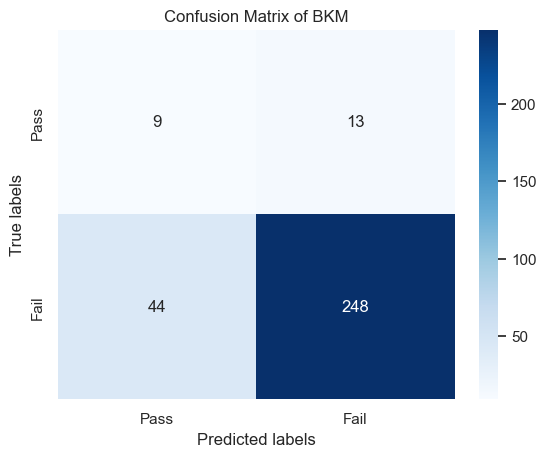

In [891]:
# plot the confusion matrix
cm = confusion_matrix(y_test,y_hat)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap=plt.cm.Blues);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of BKM'); 
ax.xaxis.set_ticklabels([ 'Pass','Fail']); ax.yaxis.set_ticklabels([ 'Pass','Fail']);

The model accuracy is 0.82, the misclassified number is 57. 

#### Build a SVC model and find the best parameter for it

In [892]:
from sklearn.svm import SVC
parameters = {'C':[1,10,100,200], 'kernel':['linear','poly','rbf'],
             'max_iter':[200,300]}
svc = SVC(random_state=401)
clf_svc= GridSearchCV(svc, parameters)
clf_svc.fit(x_train,y_train)

print(clf_svc.cv_results_.keys())
print(clf_svc.best_params_)
print(clf_svc.best_score_)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_kernel', 'param_max_iter', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'C': 1, 'kernel': 'rbf', 'max_iter': 300}
0.7023754852113061


In [893]:
svc = SVC(random_state=401,C= 1,kernel='rbf',max_iter=300).fit(x_train,y_train)
y_hat_svc=svc.predict(x_test)
print(classification_report(y_test,y_hat_svc))
y_train_pred = svc.predict(x_train)
acc_train = accuracy_score(y_train,y_train_pred)

acc = accuracy_score(y_test,y_hat_svc)

              precision    recall  f1-score   support

           0       0.13      0.32      0.19        22
           1       0.94      0.85      0.89       292

    accuracy                           0.81       314
   macro avg       0.54      0.58      0.54       314
weighted avg       0.89      0.81      0.84       314



In [894]:
compare.loc['SVC',:] = [acc_train,acc]

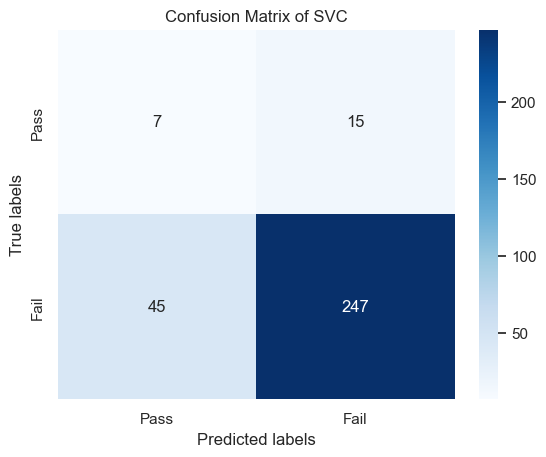

In [895]:
# plot the confusion matrix
cm = confusion_matrix(y_test,y_hat_svc)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap=plt.cm.Blues);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of SVC'); 
ax.xaxis.set_ticklabels([ 'Pass','Fail']); ax.yaxis.set_ticklabels(['Pass','Fail']);

The model accuracy is 0.81, the misclassified number is 60. 

#### Build a randomforest model and find the best parameter for it

In [896]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'n_estimators':[100,300], 'criterion':['gini','entropy','log_loss'],
             'max_depth':[2,4,6]}
rf = RandomForestClassifier(random_state=401)
clf_rf= GridSearchCV(rf, parameters)
clf_rf.fit(x_train,y_train)

print(clf_rf.cv_results_.keys())
print(clf_rf.best_params_)
print(clf_rf.best_score_)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 100}
0.8407322362546242


In [897]:
rf = RandomForestClassifier(random_state=401,criterion='gini',
                                             max_depth= 6, n_estimators= 100).fit(x_train,y_train)
y_hat_rf=rf.predict(x_test)
print(classification_report(y_test,y_hat_rf))

              precision    recall  f1-score   support

           0       0.14      0.32      0.20        22
           1       0.94      0.86      0.90       292

    accuracy                           0.82       314
   macro avg       0.54      0.59      0.55       314
weighted avg       0.89      0.82      0.85       314



In [898]:
y_train_pred = rf.predict(x_train)
acc_train = accuracy_score(y_train,y_train_pred)

acc = accuracy_score(y_test,y_hat_rf)
compare.loc['RF',:] = [acc_train,acc]

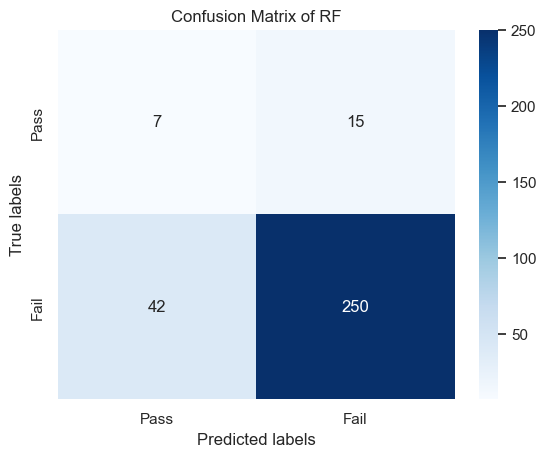

In [899]:
# plot the confusion matrix
cm = confusion_matrix(y_test,y_hat_rf)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap=plt.cm.Blues);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of RF'); 
ax.xaxis.set_ticklabels([ 'Pass','Fail']); ax.yaxis.set_ticklabels(['Pass','Fail']);

The model accuracy is 0.82, the misclassified number is 57. 

###  PCA for feature extraction 

#### Different approach to reduce the dimension of the dataset. Instead of using LASSO, I will use PCA and will build the same models and compare with the previous ones 

In [900]:
X_train_blasso.shape,y_train_blasso.shape

((1253, 211), (1253,))

Best parameter (CV score=0.935):
{'pca__n_components': 5, 'rf__max_depth': 6}


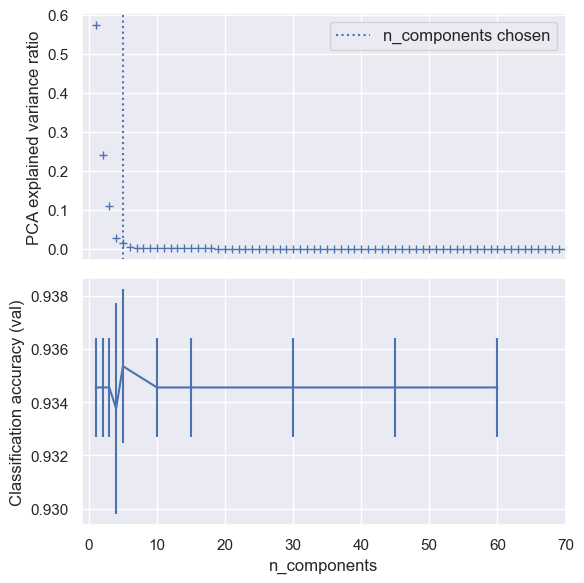

In [901]:
# pca

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

rfc = RandomForestClassifier()
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("rf", rfc)])

param_grid = {
    "pca__n_components": [1,2,3,4,5,10, 15, 30, 45, 60],
    "rf__max_depth": [2,4,6],
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train_blasso, y_train_blasso)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train_blasso)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

we can see from the plot that  perform PCA on the  data, the highest PCA explained variance ratio is a bit below 0.6 with n_components=1. The best parameter gave by the search is n_component=5, but when n_components=5, the PCA explained variance is very low, very closet to 0. it does not make sense even with the best score. so, set n_component=1. 

In [902]:
X_train_blasso = scaler.fit_transform(X_train_blasso)
X_test_blasso = scaler.transform(X_test_blasso)
pca = PCA(n_components=1)
pca.fit(X_train_blasso)
# PCA feature extraction
x_train_pca = pca.transform(X_train_blasso)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.03791417]
[100.11924473]


In [903]:
x_test_pca = pca.transform(X_test_blasso)

In [904]:
# bisectingKmeans
parameters = {'init':('k-means++', 'random'), 'n_init':[1, 10],
             'max_iter':[200,300],'algorithm':['lloyd','elkan'],
             'bisecting_strategy':['biggest_inertia','largest_cluster']}
BKM = BisectingKMeans(n_clusters=2,random_state=401)
clf = GridSearchCV(BKM, parameters)
clf.fit(x_train_pca,y_train_blasso)

print(clf.cv_results_.keys())
print(clf.best_params_)
print(clf.best_score_)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_algorithm', 'param_bisecting_strategy', 'param_init', 'param_max_iter', 'param_n_init', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'algorithm': 'lloyd', 'bisecting_strategy': 'largest_cluster', 'init': 'k-means++', 'max_iter': 200, 'n_init': 1}
-493.7807937497631


In [905]:
x_train_pca.shape,x_test_pca.shape,y_train_blasso.shape,y_test_blasso.shape

((1253, 1), (314, 1), (1253,), (314,))

              precision    recall  f1-score   support

           0       0.08      0.64      0.14        22
           1       0.94      0.43      0.59       292

    accuracy                           0.45       314
   macro avg       0.51      0.53      0.37       314
weighted avg       0.88      0.45      0.56       314



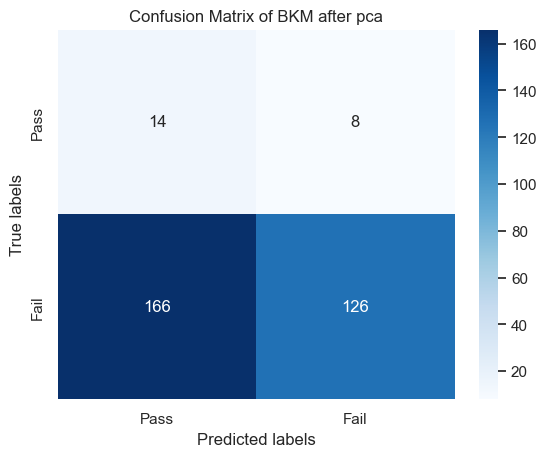

In [906]:
bisect_means_pca = BisectingKMeans(n_clusters=2,random_state=401,init='k-means++',
                               n_init=1,bisecting_strategy='largest_cluster',
                              algorithm='lloyd',max_iter=200).fit(x_train_pca)
y_hat_pca_bkm=bisect_means_pca.predict(x_test_pca)
y_hat_pca_bkm = [1 if x==0 else 0 for x in y_hat_pca_bkm]
print(classification_report(y_test_blasso,y_hat_pca_bkm))

y_train_pred = bisect_means_pca.predict(x_train_pca)
y_train_pred = [1 if x==0 else 0 for x in y_train_pred]
acc_train = accuracy_score(y_train_blasso,y_train_pred)
acc = accuracy_score(y_test_blasso,y_hat_pca_bkm)

compare.loc['BKM_PCA',:] = [acc_train,acc]
cm =confusion_matrix(y_test_blasso,y_hat_pca_bkm)
# plot the confusion matrix

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap=plt.cm.Blues);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of BKM after pca'); 
ax.xaxis.set_ticklabels([ 'Pass','Fail']); ax.yaxis.set_ticklabels([ 'Pass','Fail']);

In [907]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test_blasso,y_hat_pca_bkm)

0.035026365191625566

The model has a accuracy of 0.45, which is really low. The matthew correlation coefficient is 0.035 and is very close to 0. It means the model is expected for a prediction no better than random, and the model is not performing well.

In [908]:
# svc
parameters = {'C':[1,10,100,200], 'kernel':['linear','poly','rbf'],
             'max_iter':[200,300]}
svc = SVC(random_state=401)
clf_svc= GridSearchCV(svc, parameters)
clf_svc.fit(x_train_pca,y_train_blasso)

print(clf_svc.cv_results_.keys())
print(clf_svc.best_params_)
print(clf_svc.best_score_)


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_kernel', 'param_max_iter', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'C': 1, 'kernel': 'linear', 'max_iter': 200}
0.9345593625498008


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.93      1.00      0.96       292

    accuracy                           0.93       314
   macro avg       0.46      0.50      0.48       314
weighted avg       0.86      0.93      0.90       314



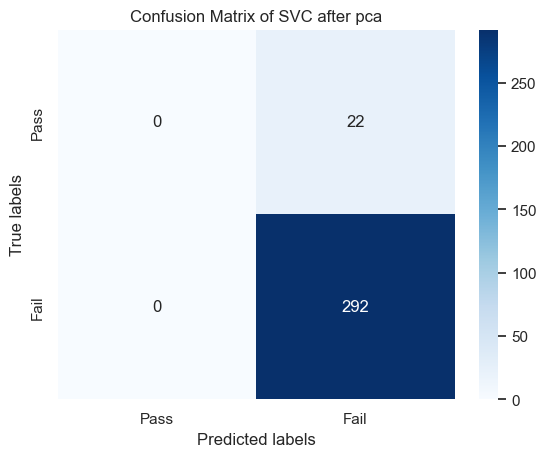

In [909]:
svc = SVC(random_state=401,C= 1,kernel='linear',max_iter=200).fit(x_train_pca,y_train_blasso)
y_hat_pca_svc=svc.predict(x_test_pca)
print(classification_report(y_test_blasso,y_hat_pca_svc))
y_train_pred = svc.predict(x_train_pca)
acc_train = accuracy_score(y_train_blasso,y_train_pred)
acc = accuracy_score(y_test_blasso,y_hat_pca_svc)

compare.loc['SVC_PCA',:] = [acc_train,acc]
cm =confusion_matrix(y_test_blasso,y_hat_pca_svc)
# plot the confusion matrix

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap=plt.cm.Blues);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of SVC after pca'); 
ax.xaxis.set_ticklabels([ 'Pass','Fail']); ax.yaxis.set_ticklabels([ 'Pass','Fail']);

In [910]:
matthews_corrcoef(y_test_blasso,y_hat_pca_svc)

0.0

- The modle has accuracy 0.93 but it only predicted one class. From the confusion matrix, we can see that it is the fail class. Because the data has very unbalanced class, simply predict all the label as the majority class, it will yeil a good accuracy. But the model is useless. 
- The matthew correlation coefficient is 0.0 . It means the model is expected for a prediction no better than random, and the model is not performing well.

In [911]:
# random forest

parameters = {'n_estimators':[100,300], 'criterion':['gini','entropy','log_loss'],
             'max_depth':[2,4,6]}
rf = RandomForestClassifier(random_state=401)
clf_rf= GridSearchCV(rf, parameters)
clf_rf.fit(x_train_pca,y_train_blasso)

print(clf_rf.cv_results_.keys())
print(clf_rf.best_params_)
print(clf_rf.best_score_)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}
0.9345593625498008


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.93      1.00      0.96       292

    accuracy                           0.93       314
   macro avg       0.46      0.50      0.48       314
weighted avg       0.86      0.93      0.90       314



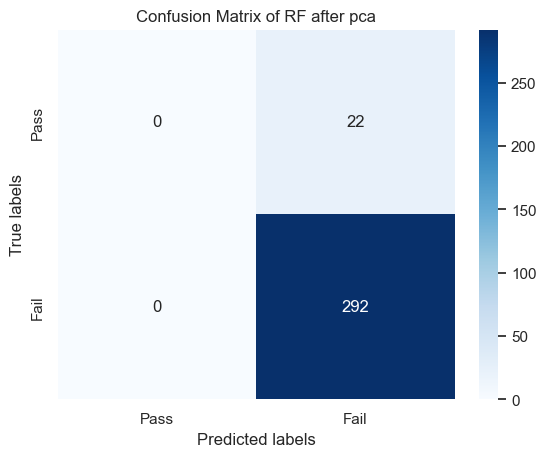

In [912]:
rf = RandomForestClassifier(random_state=401,criterion='gini',
                                             max_depth= 2, n_estimators= 100).fit(x_train_pca,y_train_blasso)
y_hat_pca_rf=rf.predict(x_test_pca)
print(classification_report(y_test_blasso,y_hat_pca_rf))
y_train_pred = rf.predict(x_train_pca)
acc_train = accuracy_score(y_train_blasso,y_train_pred)
acc = accuracy_score(y_test_blasso,y_hat_pca_rf)
compare.loc['RF_PCA',:] = [acc_train,acc]
cm =confusion_matrix(y_test_blasso,y_hat_pca_rf)
# plot the confusion matrix

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap=plt.cm.Blues);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of RF after pca'); 
ax.xaxis.set_ticklabels([ 'Pass','Fail']); ax.yaxis.set_ticklabels([ 'Pass','Fail']);

In [913]:
matthews_corrcoef(y_test_blasso,y_hat_pca_rf)

0.0

- The modle has accuracy 0.93 but it only predicted one class. From the confusion matrix, we can see that it is the fail class. Because the data has very unbalanced class, simply predict all the label as the majority class, it will yeil a good accuracy. But the model is useless. 
- The matthew correlation coefficient is 0.0 . It means the model is expected for a prediction no better than random, and the model is not performing well.

In [914]:
compare

,training_acc,testing_acc
BKM,0.699829,0.818471
SVC,0.752348,0.808917
RF,0.893254,0.818471
BKM_PCA,0.426177,0.44586
SVC_PCA,0.934557,0.929936
RF_PCA,0.934557,0.929936


### Conclusion and Discussion

- There are 6 models, two of them are using unsupervised clustering algorithms and the other four are using supervised machine learning algorithms. The unsupervised clustering models are bisecting k-means. Bisecting K-means is a modification to the regular k-means algorithm. The supervised modles are supert vector machine and random forest models.
- The first three models were built after performed LASSO technique to reduce feature numbers to 5. The BKM and SVC,RF models have similar testing model accuracy (around 0.81), but very different training accuracy. The BKM has the smallest training accuracy and RF has the largest. The training accuracy of the random forest model is bigger than its testing accuracy, the model is overfitted.
- The second apporach was not using LASSO technique to reduce feature numbers but to use PCA to extrac features. After PCA, same types of three models were built. The unsupervised BKM model has the lowest training accuracy and testing accuracy. Both SVC_PCA and RF_PCA models has good training and testing accuracy score, but if take a closer look at their confusion matrics, the models only predicted one class which is fail. In this case, these two models are useless even with high accuracy acores. This is becasue the model has very unbalanced class, and even with SMOTE techinque to resample classes, there are still limitations in these models to capture more relationship between features and classes. Some better models like RNN would work better.
